# Example: VAE rapid Cell EL processing
Steps:
- Segment the example EL images with MultiSolSegment
- Pass them through the latent space to parametrize
- Visualize the latent space and cluster the images

In this example we are not informing on power loss just aiding with the visual inspection of the EL images and clustering them automatically

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parents[1]
os.chdir(project_root)   # now cwd is .../pvcracks

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pvcracks.utils import train_functions
from pvcracks.utils.segmentation import segment

import requests

from PIL import Image

from pvcracks.vae.VAE_model_3CH import VAE

In [2]:
root = Path.cwd()
print(root) #should be root of the repo

/home/nrjost/githome/pvcracks


#### Set device for torch

In [3]:
#GPU or CPU
print(f"Are we using the GPU: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Are we using the GPU: True


#### Load 3CH VAE model with weights (https://doi.org/10.21948/2997860)

In [4]:
from io import BytesIO

# Load from Datahub
url = "https://datahub.duramat.org/dataset/919a555d-dd97-46ad-b77c-ae7e8894e6c4/resource/e83785e1-ba34-4212-b519-c6535b3e6804/download/model_3ch_233_weights.pth"
#Link from the project folder: https://datahub.duramat.org/dataset/pvcracks-trained-vae-model

#Download from url
response = requests.get(url)
if response.status_code == 200:
    model = VAE(latent_dim=50)  # Create an instance of your model
    model.load_state_dict(torch.load(BytesIO(response.content), weights_only=True))
    model.to(device)  # Move to the appropriate device
else:
    print(f"Failed to download model. Status code: {response.status_code}")

#Evaluate model
model.eval()

Linear(in_features=50176, out_features=50, bias=True)
Linear(in_features=50176, out_features=50, bias=True)


VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (7): ReLU()
      (8): Conv2d(256, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (9): ReLU()
      (10): Conv2d(512, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (11): ReLU()
    )
    (fc_mu): Linear(in_features=50176, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=50176, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=50, out_features=50176, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
   

#### Download MutiSolSegment weights (https://doi.org/10.21948/2997859)

In [5]:
weight_path = "multisolsegment.pt"
response = requests.get("https://datahub.duramat.org/dataset/24d7ed98-956e-4ebc-bf21-6584ecec2ff1/resource/e6d5dee2-0aef-439e-978c-d8c572e7039e/download/model.pt")

with open(weight_path, "wb") as f:
    f.write(response.content)

#### Load model MultisolSegment (moduleMMS)

In [6]:
category_mapping = {0: "dark", 1: "busbar", 2: "crack", 3: "non-cell"}

device, modelMSS = train_functions.load_device_and_model(
    category_mapping, existing_weight_path=weight_path
)

#### Example EL Images

In [7]:
Cell9Master = pd.read_csv('docs/data/ELdata_module_209.csv', index_col=0)

#### Load EL Images convert, resize and **segment**


In [8]:
from torchvision import transforms
import torchvision.transforms.functional as F

# these lists will hold your raw model outputs (dtype=float32), each of shape (400,400)
seg_crack = []
seg_bb    = []
seg_dark  = []
worked_paths = []

for idx, row in Cell9Master.iterrows():
    img_path = f"{os.getcwd()}{row.ELPath}"
    try:
        # 1) load + convert + rotate
        img = Image.open(img_path).convert("RGB").rotate(90)

        # 2) resize to 400×400 for your segment() call
        img400 = F.resize(
            img,
            (400, 400),
            interpolation=transforms.InterpolationMode.BILINEAR
        )

        # 3) segment → returns (dark, bb, crack, nocell)
        dark, bb, crack, nocell = segment(img400, device, modelMSS)

        # 4) store as float32
        seg_crack.append(crack.astype(np.float32))
        seg_bb   .append(bb   .astype(np.float32))
        seg_dark .append(dark .astype(np.float32))

        worked_paths.append(row.ELPath) #log paths for images that worked

    except Exception as e:
        print(f"⚠️ failed on {img_path}: {e}")


#### Check if all images could be segmented

In [9]:
Cell9Master['ELPath'].isin(worked_paths)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
Name: ELPath, dtype: bool

#### Combine the masks for the 3Channel-VAE

In [10]:
import numpy as np

combined_list = []

for c_raw, b_raw, d_raw in zip(seg_crack, seg_bb, seg_dark):
    # 1) binarize each channel by its mean
    c_bin = (c_raw > c_raw.mean()).astype(np.float32)
    b_bin = (b_raw > b_raw.mean()).astype(np.float32)
    d_bin = (d_raw > d_raw.mean()).astype(np.float32)

    # 2) stack into (3,400,400) in the order [crack, bb, dark]
    sample = np.stack([c_bin, b_bin, d_bin], axis=0)
    combined_list.append(sample)

# 3) stack all samples into (N,3,400,400)
combined = np.stack(combined_list, axis=0)
print("combined.shape =", combined.shape)

combined.shape = (27, 3, 400, 400)


#### Send the images through the VAE

In [11]:
from pvcracks.vae.VAE_functions import encode_image, decode_latent_vector

lat_vectors = []

for sample in combined:  
    # 1) turn into a 3D torch tensor (C,H,W) & send to device
    img_in = torch.from_numpy(sample).to(device)  

    # 2) encode → latent vector
    with torch.no_grad():
        lat = encode_image(model, img_in)

    # stash a CPU copy
    lat_vectors.append(lat.cpu())

    # 3) decode
    with torch.no_grad():
        rec = decode_latent_vector(model, lat.to(device))
    # rec shape is (1,3,400,400) → squeeze out the batch
    rec = rec.squeeze(0).cpu().numpy()

torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])


#### Make a dataframe with the latent vectors

In [12]:
#We do this for worked paths
df_space = Cell9Master[Cell9Master['ELPath'].isin(worked_paths)]
lat_vectors_cpu = [lat_vector.squeeze().cpu().numpy() for lat_vector in lat_vectors]
df_space['lat_vec'] = lat_vectors_cpu
df_space.lat_vec

0     [-0.33250138, 0.9893119, -0.61522657, -0.12483...
1     [-0.15656391, 0.6889924, 1.4591371, -1.9122308...
2     [0.31856775, 1.6780007, -0.44112492, 0.14683, ...
3     [-0.68114537, 1.6457926, -0.61010593, -0.87041...
4     [-0.41167215, 1.1730539, -1.334518, -1.4193864...
5     [-0.78635216, 1.5814315, 1.6481582, -0.9483758...
6     [1.3313957, 1.4688822, 0.33593652, -0.5598694,...
7     [0.3311233, 2.101786, -1.9322172, -1.2864361, ...
8     [-0.01631616, 0.9955636, 0.035341755, -0.57192...
9     [-0.35740757, 2.0590327, 0.7615145, -0.3968444...
10    [-0.3041548, 1.3618469, -1.1628541, -1.9601784...
11    [-0.2638254, 2.07125, -1.516976, -1.4502783, -...
12    [0.7082361, -0.020961849, 0.64100033, -0.91406...
13    [-0.45681447, 1.8222392, -1.6409351, -2.310123...
14    [-0.16110525, 0.89159304, -1.0482608, -1.87652...
15    [0.82473654, 1.3554066, -0.9948655, -0.5063201...
16    [-0.6412171, 1.7541218, -1.6422628, -2.077641,...
17    [-0.03508939, 1.4184563, 1.2639252, -0.777

#### Visualize the latent space
- Do principal component analysis (PCA) to reduce the dimension to 3.
- k-means to cluster the reduced dimensions

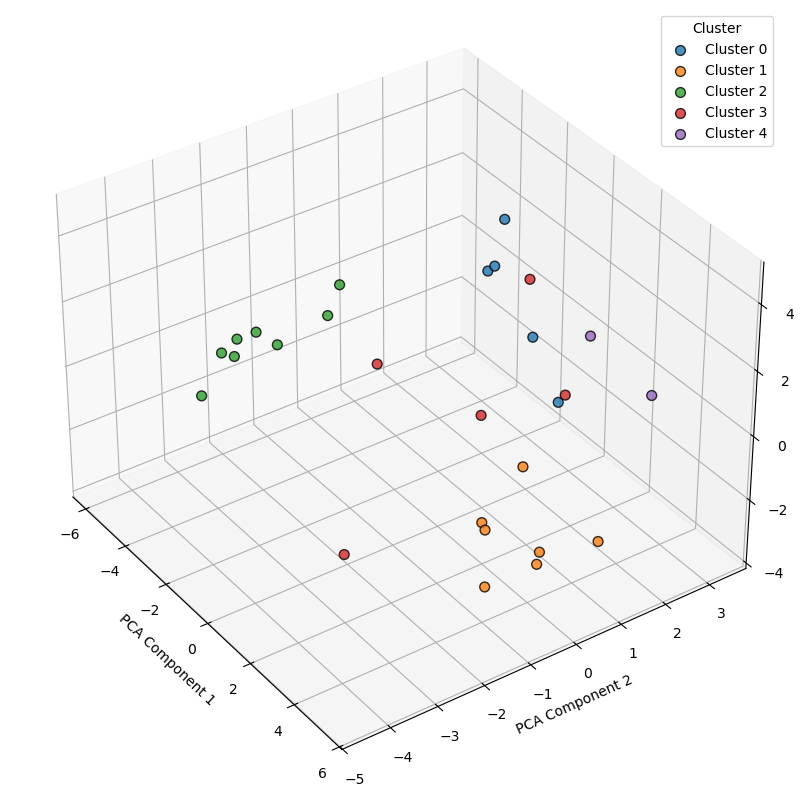

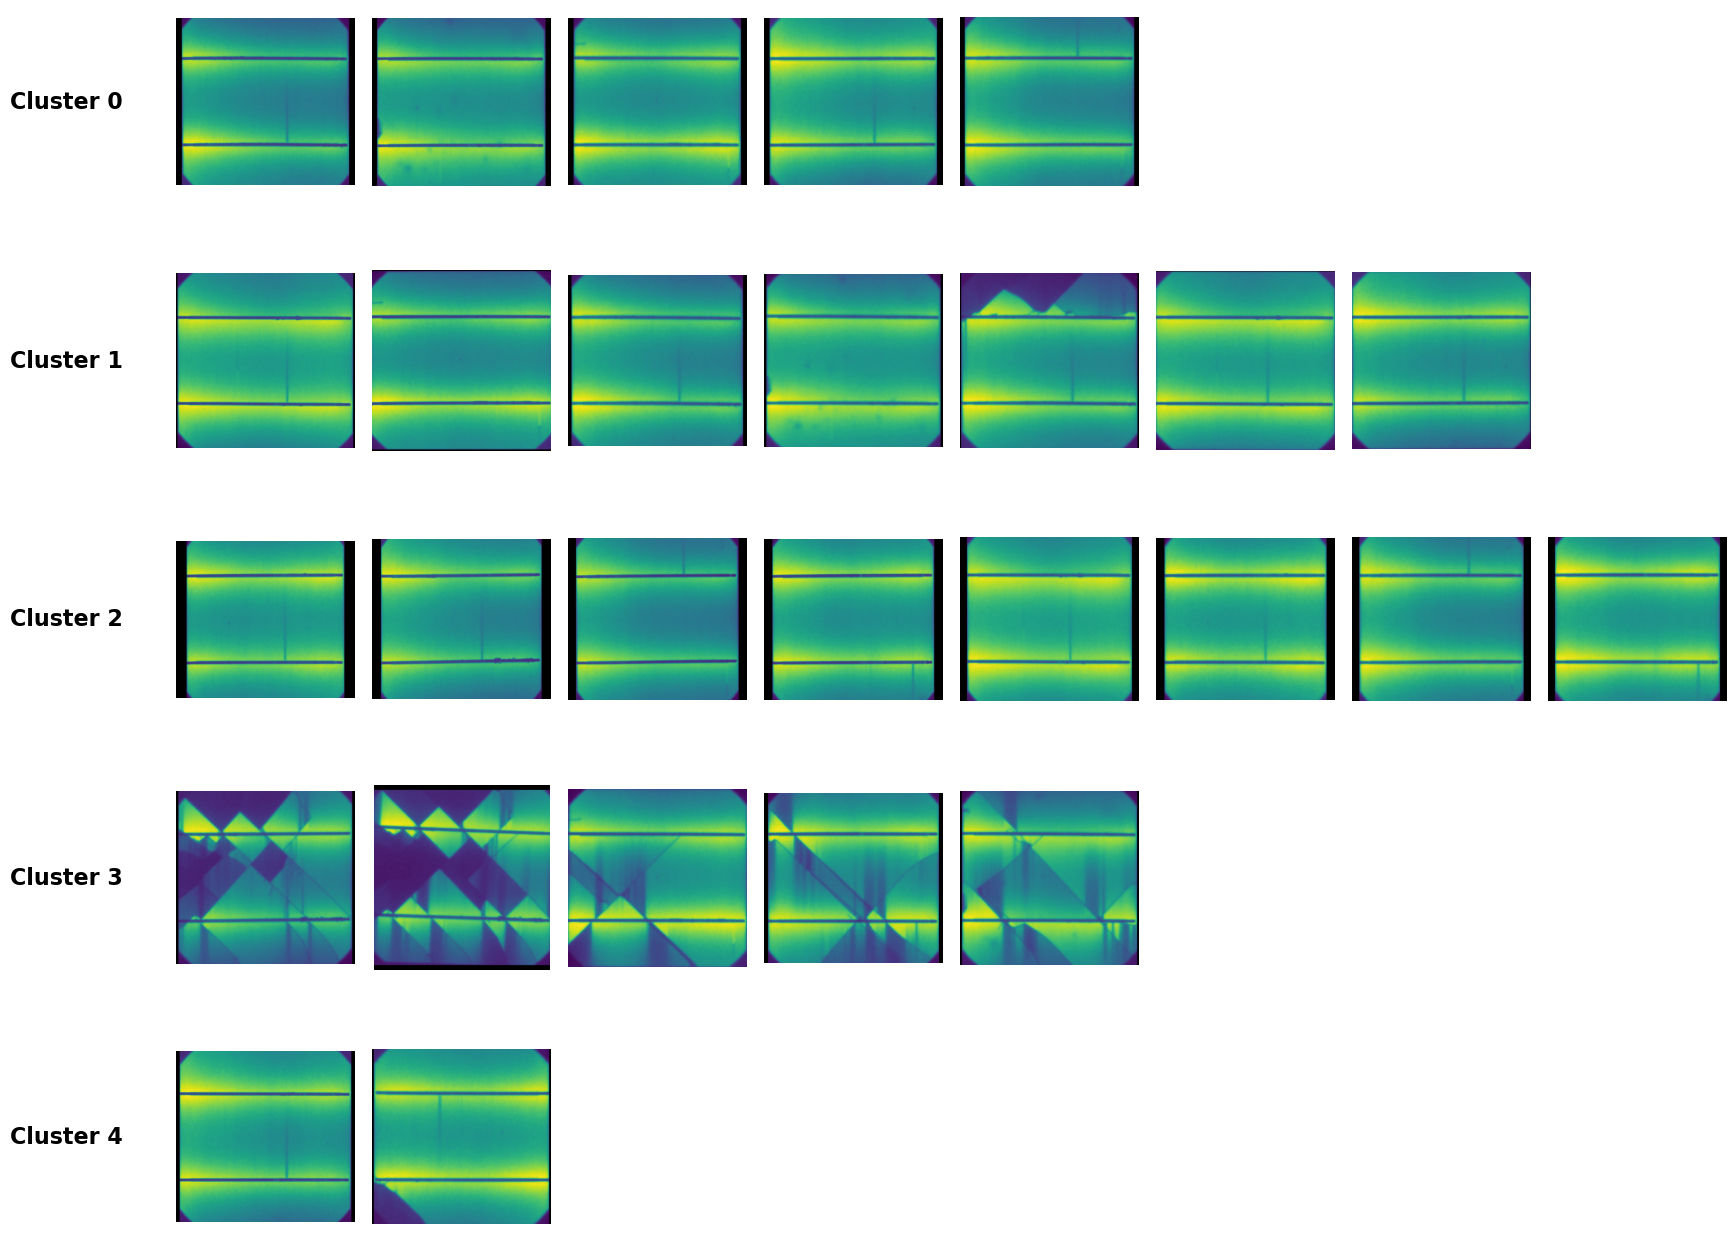

In [13]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import gridspec

# 1) Build a (N, D) array of your latent vectors
latent_array = np.stack(df_space['lat_vec'].to_list())  

# 2) PCA → 3 dims
pca = PCA(n_components=3, random_state=0)
data_reduced = pca.fit_transform(latent_array)          

# 3) KMeans → different cluster sizes can be used here
kmeans = KMeans(n_clusters=5, random_state=0)
df_space['klabel'] = kmeans.fit_predict(data_reduced)

# 4) 3-D scatter plot of the latent space
fig1 = plt.figure(figsize=(10, 8))
ax1  = fig1.add_subplot(111, projection='3d')          
for lbl in np.unique(df_space['klabel']):
    mask = df_space['klabel'] == lbl
    ax1.scatter(
        data_reduced[mask, 0],
        data_reduced[mask, 1],
        data_reduced[mask, 2],
        c=f'C{int(lbl)}',
        label=f'Cluster {lbl}',
        s=50,
        edgecolor='k',
        alpha=0.8
    )
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('PCA Component 3')
ax1.view_init(elev=35, azim=-35)
ax1.legend(title='Cluster')
plt.tight_layout()
plt.show()                                          

# 5) Plot the EL images of each cluster below
n_clusters    = df_space['klabel'].nunique()
imgs_per_clus = 8

fig2 = plt.figure(figsize=(20, 4*(n_clusters+1)))
gs   = gridspec.GridSpec(
    n_clusters+1,
    imgs_per_clus,
    height_ratios=[3] + [1]*n_clusters,
    hspace=0.3,
    wspace=0.1
)

for i, lbl in enumerate(sorted(df_space['klabel'].unique())):
    paths = df_space.query('klabel == @lbl')['ELPath'].tolist()[:imgs_per_clus]
    for j in range(imgs_per_clus):
        ax = fig2.add_subplot(gs[i+1, j])
        if j < len(paths):
            img_path = f"{os.getcwd()}{paths[j]}"
            try:
                img = Image.open(img_path).convert("RGB").rotate(90)
                ax.imshow(img, cmap='gray')
            except Exception:
                ax.text(0.5, 0.5, "Load failed", ha='center', va='center')
        ax.axis('off')
        if j == 0:
            ax.text(
                -0.3, 0.5,
                f'Cluster {lbl}',
                transform=ax.transAxes,
                fontsize=16,
                fontweight='bold',
                va='center',
                ha='right'
            )

plt.show()  

#### Save the results

In [14]:
df_space.to_csv("docs/data/ELdata_module_209_VAE_analysis.csv")